# Cell Proliferation Analysis

This notebook visualizes cell proliferation dynamics by analyzing nuclei counts over time across different conditions. It loads data from CSV files generated by the `plot_nuclei_over_time.py` script.

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

## Load Data

Define paths to the CSV files for different conditions.

In [16]:
# Base directory for results
results_base = "../../results/t2v"

# Dictionary to store DataFrames for different conditions
data_dict = {}

# Function to load data and add condition info
def load_data(subdir, condition_name):
    path = os.path.join(results_base, subdir, "nuclei_counts_over_time.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        df['condition'] = condition_name  # Add condition column
        return df
    else:
        print(f"Warning: {path} not found")
        return None

# Load data for different conditions
# Real data
data_dict['real_ALL'] = load_data("IDR0013-FILTERED-Test", "Real videos")
# data_dict['real_pr_HIGH'] = load_data("IDR0013-FILTERED-Test-pr-HIGH", "Real Proliferation HIGH")
# data_dict['real_pr_LOW'] = load_data("IDR0013-FILTERED-Test-pr-LOW", "Real Proliferation LOW")
# data_dict['real_ms_HIGH'] = load_data("IDR0013-FILTERED-Test-ms-HIGH", "Real Migration HIGH")
# data_dict['real_ms_LOW'] = load_data("IDR0013-FILTERED-Test-ms-LOW", "Real Migration LOW")
# data_dict['real_cc_HIGH'] = load_data("IDR0013-FILTERED-Test-cc-HIGH", "Real Cell Count HIGH")
# data_dict['real_cc_LOW'] = load_data("IDR0013-FILTERED-Test-cc-LOW", "Real Cell Count LOW")

# Generated data - Unconditional
data_dict['uncond_frames81'] = load_data("uncond_frames81", "Unconditional (81 frames)")
data_dict['uncond_frames129'] = load_data("uncond_frames129", "Unconditional")

# # Generated data - Text-conditioned
# data_dict['prompt_pr_HIGH'] = load_data("prompt_pr_pr-HIGH", "Text Prompt Proliferation HIGH")
# data_dict['prompt_pr_LOW'] = load_data("prompt_pr_pr-LOW", "Text Prompt Proliferation LOW")
# data_dict['prompt_ms_HIGH'] = load_data("prompt_ms_ms-HIGH", "Text Prompt Migration HIGH")
# data_dict['prompt_ms_LOW'] = load_data("prompt_ms_ms-LOW", "Text Prompt Migration LOW")
# data_dict['prompt_cc_HIGH'] = load_data("prompt_cc_cc-HIGH", "Text Prompt Cell Count HIGH")
# data_dict['prompt_cc_LOW'] = load_data("prompt_cc_cc-LOW", "Text Prompt Cell Count LOW")

# # Generated data - Phenotype-conditioned
# data_dict['phenotype_pr_HIGH'] = load_data("phenotype_pr_pr-HIGH", "Phenotype Proliferation HIGH")
# data_dict['phenotype_pr_LOW'] = load_data("phenotype_pr_pr-LOW", "Phenotype Proliferation LOW")
# data_dict['phenotype_ms_HIGH'] = load_data("phenotype_ms_ms-HIGH", "Phenotype Migration HIGH")
# data_dict['phenotype_ms_LOW'] = load_data("phenotype_ms_ms-LOW", "Phenotype Migration LOW")
# data_dict['phenotype_cc_HIGH'] = load_data("phenotype_cc_cc-HIGH", "Phenotype Cell Count HIGH")
# data_dict['phenotype_cc_LOW'] = load_data("phenotype_cc_cc-LOW", "Phenotype Cell Count LOW")

# Filter out missing entries
data_dict = {k: v for k, v in data_dict.items() if v is not None}

## Compare Proliferation Dynamics

First, let's look at the average proliferation curves for different conditions.

In [25]:
def plot_average_growth(data_keys, title="Average Nuclei Growth Over Time", max_frame=None):
    plt.figure(figsize=(14, 8))
    
    for key in data_keys:
        if key not in data_dict:
            print(f"Warning: {key} not in data_dict. Skipping.")
            continue
            
        df = data_dict[key]
        
        # Limit to max_frame if specified
        if max_frame is not None:
            df = df[df['frame'] <= max_frame]
            
        # Calculate mean and standard error for each frame
        grouped = df.groupby('frame')['nuclei_count'].agg(['mean', 'sem', 'count'])
        
        # Plot mean line
        plt.plot(grouped.index, grouped['mean'], label=f"{data_dict[key]['condition'].iloc[0]}")

        
        # Add confidence interval
        plt.fill_between(grouped.index, 
                         grouped['mean'] - grouped['sem'], 
                         grouped['mean'] + grouped['sem'], 
                         alpha=0.3)
    
    plt.axvline(x=80, color='r', linestyle='--', label="Training Sequence Length")
    plt.xlabel('Frame')
    plt.ylabel('Average Number of Nuclei')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Real vs. Generated - Proliferation

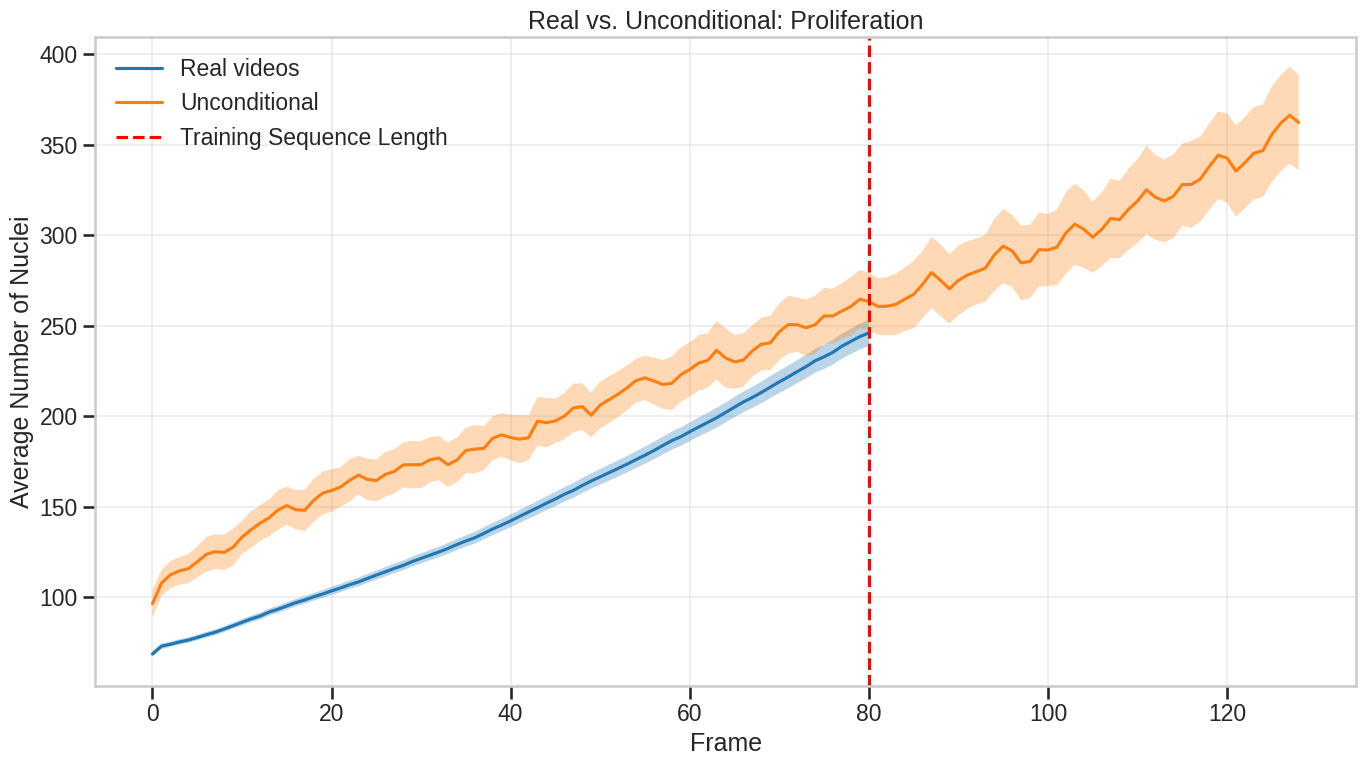

In [27]:
# Compare real vs. unconditional for proliferation
plot_average_growth(
    ["real_ALL", 'uncond_frames129',],
    title="Real vs. Unconditional: Proliferation"
)

In [ ]:
# Compare real vs. text-conditioned for proliferation
plot_average_growth(
    ['real_pr_HIGH', 'real_pr_LOW', 'prompt_pr_HIGH', 'prompt_pr_LOW'],
    title="Real vs. Text-Conditioned: Proliferation"
)

In [ ]:
# Compare real vs. phenotype-conditioned for proliferation
plot_average_growth(
    ['real_pr_HIGH', 'real_pr_LOW', 'phenotype_pr_HIGH', 'phenotype_pr_LOW'],
    title="Real vs. Phenotype-Conditioned: Proliferation"
)

### Real vs. Generated - Initial Cell Count

In [ ]:
plot_average_growth(
    ['real_cc_HIGH', 'real_cc_LOW', 'prompt_cc_HIGH', 'prompt_cc_LOW'],
    title="Real vs. Text-Conditioned: Initial Cell Count"
)

## Extended Sequence Analysis

Let's examine if models can generate stable extended sequences beyond the training length (81 frames).

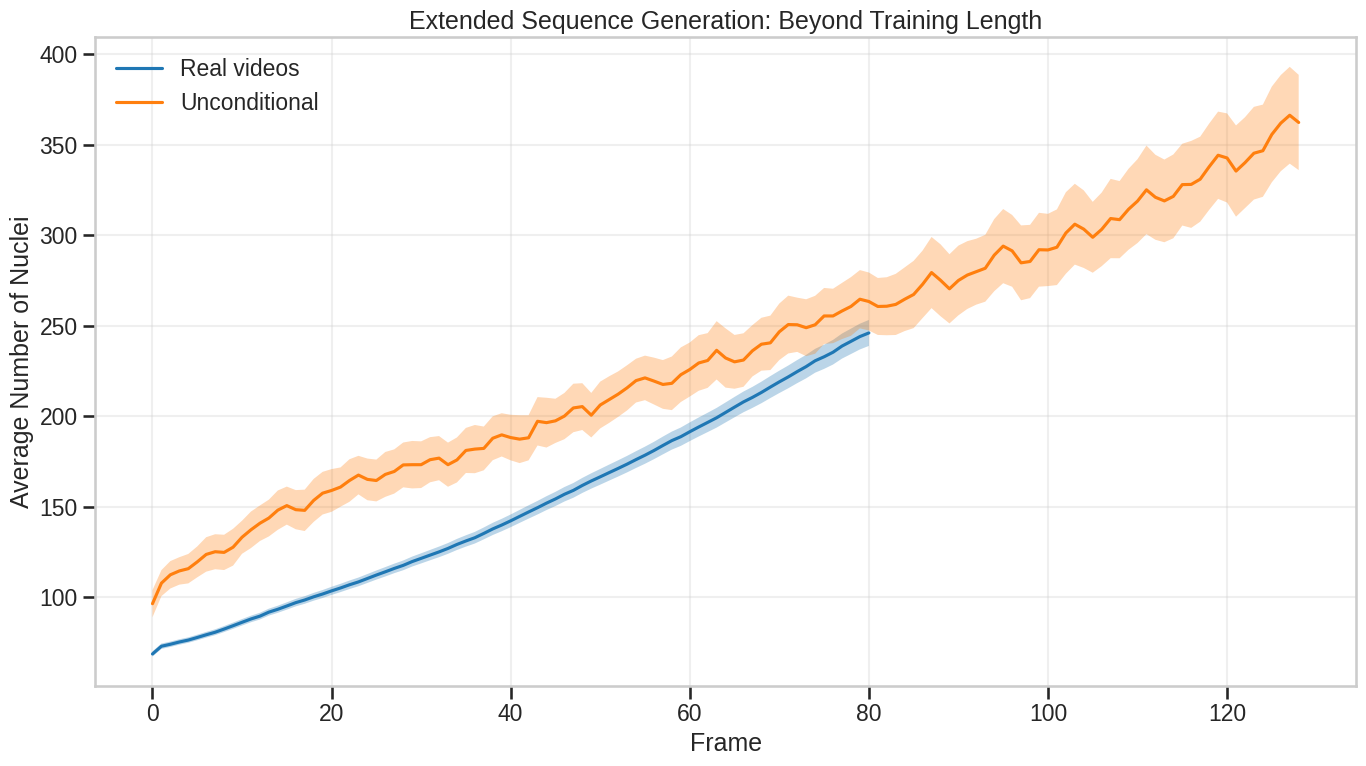

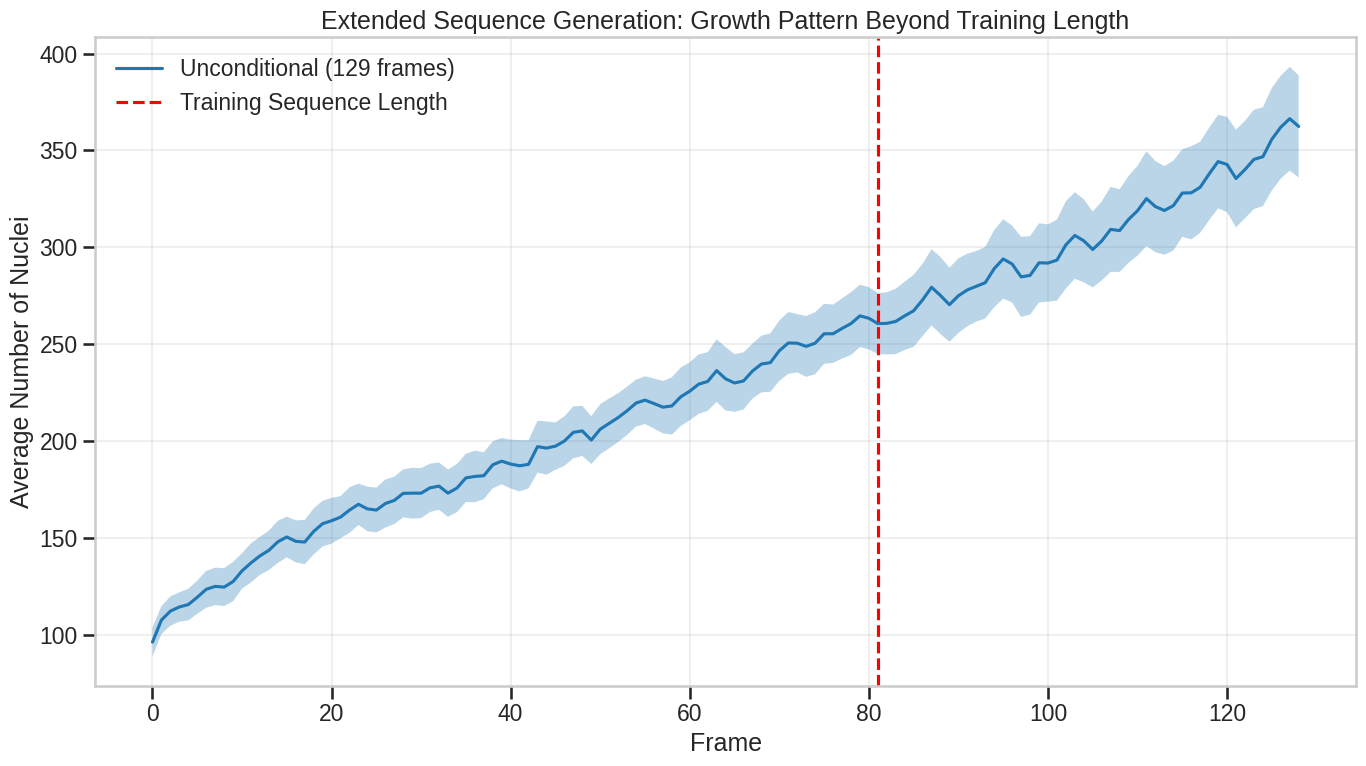

In [20]:
if 'uncond_frames129' in data_dict:
    # Plot extended frame videos
    plot_average_growth(
        ['real_ALL', 'uncond_frames129'],
        title="Extended Sequence Generation: Beyond Training Length",
        max_frame=128
    )
    
    # Add a vertical line at frame 81 (training boundary)
    plt.figure(figsize=(14, 8))
    
    df = data_dict['uncond_frames129']
    grouped = df.groupby('frame')['nuclei_count'].agg(['mean', 'sem'])
    
    plt.plot(grouped.index, grouped['mean'], label="Unconditional (129 frames)")
    plt.fill_between(grouped.index, grouped['mean'] - grouped['sem'], grouped['mean'] + grouped['sem'], alpha=0.3)
    
    plt.axvline(x=81, color='r', linestyle='--', label="Training Sequence Length")
    
    plt.xlabel('Frame')
    plt.ylabel('Average Number of Nuclei')
    plt.title("Extended Sequence Generation: Growth Pattern Beyond Training Length")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Extended sequence data not available")

## Growth Statistics

Let's calculate some key statistics about growth patterns.

In [ ]:
def calculate_growth_stats(data_dict):
    # Create a list to store results
    results = []
    
    for key, df in data_dict.items():
        # Get unique videos
        videos = df['video_name'].unique()
        
        video_stats = []
        for video in videos:
            video_df = df[df['video_name'] == video].sort_values('frame')
            
            # Calculate statistics
            initial_count = video_df.iloc[0]['nuclei_count']
            final_count = video_df.iloc[-1]['nuclei_count']
            
            if initial_count > 0:
                growth_ratio = final_count / initial_count
            else:
                growth_ratio = np.nan
                
            growth_absolute = final_count - initial_count
            
            # Calculate average growth rate (nuclei per frame)
            frames = len(video_df)
            if frames > 1:
                growth_rate = growth_absolute / (frames - 1)
            else:
                growth_rate = 0
                
            video_stats.append({
                'video': video,
                'condition': df['condition'].iloc[0],
                'initial_count': initial_count,
                'final_count': final_count,
                'growth_ratio': growth_ratio,
                'growth_absolute': growth_absolute,
                'growth_rate': growth_rate,
                'frames': frames
            })
            
        # Add individual video stats
        for stat in video_stats:
            results.append(stat)
    
    return pd.DataFrame(results)

# Calculate statistics
growth_stats = calculate_growth_stats(data_dict)

# Calculate aggregated statistics by condition
condition_stats = growth_stats.groupby('condition').agg({
    'initial_count': ['mean', 'std'],
    'final_count': ['mean', 'std'],
    'growth_ratio': ['mean', 'std'],
    'growth_absolute': ['mean', 'std'],
    'growth_rate': ['mean', 'std'],
    'video': 'count'
}).rename(columns={'video': 'count'})

# Display condition statistics
condition_stats

## Visualize Growth Distributions

Let's plot the distributions of growth metrics to better understand the differences between conditions.

In [ ]:
def plot_growth_metric_comparison(growth_stats, metric, conditions, title=None):
    # Filter data for selected conditions
    filtered_data = growth_stats[growth_stats['condition'].isin(conditions)]
    
    plt.figure(figsize=(14, 8))
    
    # Create violin plot
    sns.violinplot(x='condition', y=metric, data=filtered_data, inner='box')
    
    # Add individual points
    sns.stripplot(x='condition', y=metric, data=filtered_data, 
                  size=4, color='black', alpha=0.5)
    
    plt.title(title or f'Distribution of {metric} by Condition')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Calculate statistical significance (t-test) between pairs of conditions
    if len(conditions) > 1:
        print(f"\nStatistical Tests for {metric}:")
        for i, cond1 in enumerate(conditions[:-1]):
            for cond2 in conditions[i+1:]:
                data1 = filtered_data[filtered_data['condition'] == cond1][metric].dropna()
                data2 = filtered_data[filtered_data['condition'] == cond2][metric].dropna()
                
                if len(data1) > 0 and len(data2) > 0:
                    t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
                    print(f"{cond1} vs {cond2}: t={t_stat:.2f}, p={p_val:.4f}{' *' if p_val < 0.05 else ''}")

In [ ]:
# Compare growth ratio for real vs. text-conditioned proliferation
plot_growth_metric_comparison(
    growth_stats, 
    'growth_ratio',
    ['Real Proliferation HIGH', 'Real Proliferation LOW', 
     'Text Prompt Proliferation HIGH', 'Text Prompt Proliferation LOW'],
    'Growth Ratio: Real vs. Text-Conditioned Proliferation'
)

In [ ]:
# Compare initial count for real vs. text-conditioned cell count
plot_growth_metric_comparison(
    growth_stats, 
    'initial_count',
    ['Real Cell Count HIGH', 'Real Cell Count LOW', 
     'Text Prompt Cell Count HIGH', 'Text Prompt Cell Count LOW'],
    'Initial Cell Count: Real vs. Text-Conditioned'
)

## Calculate Wasserstein Distances

The Wasserstein distance provides a metric for comparing the distributions between real and generated data.

In [ ]:
def calculate_wasserstein_distances(growth_stats, metric, real_conditions, gen_conditions):
    results = []
    
    for real_cond in real_conditions:
        for gen_cond in gen_conditions:
            real_data = growth_stats[growth_stats['condition'] == real_cond][metric].dropna()
            gen_data = growth_stats[growth_stats['condition'] == gen_cond][metric].dropna()
            
            if len(real_data) > 0 and len(gen_data) > 0:
                # Calculate Wasserstein distance
                distance = stats.wasserstein_distance(real_data, gen_data)
                
                results.append({
                    'Real Condition': real_cond,
                    'Generated Condition': gen_cond,
                    'Metric': metric,
                    'Wasserstein Distance': distance
                })
    
    return pd.DataFrame(results)

# Define condition groups for comparison
real_pr_conditions = ['Real Proliferation HIGH', 'Real Proliferation LOW']
gen_pr_conditions = ['Text Prompt Proliferation HIGH', 'Text Prompt Proliferation LOW', 
                     'Phenotype Proliferation HIGH', 'Phenotype Proliferation LOW',
                     'Unconditional (81 frames)']

# Calculate Wasserstein distances for various metrics
wasserstein_results = pd.concat([
    calculate_wasserstein_distances(growth_stats, 'growth_ratio', real_pr_conditions, gen_pr_conditions),
    calculate_wasserstein_distances(growth_stats, 'final_count', real_pr_conditions, gen_pr_conditions),
    calculate_wasserstein_distances(growth_stats, 'growth_rate', real_pr_conditions, gen_pr_conditions)
])

# Display results
wasserstein_results.sort_values(['Metric', 'Real Condition', 'Wasserstein Distance'])

## Visualization for Publication

Let's create a publication-ready figure comparing real and generated proliferation curves.

In [ ]:
def create_publication_figure():
    # Set style for publication
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial']
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: HIGH proliferation comparison
    ax = axes[0]
    
    plot_keys = ['real_pr_HIGH', 'prompt_pr_HIGH', 'phenotype_pr_HIGH']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for i, key in enumerate([k for k in plot_keys if k in data_dict]):
        df = data_dict[key]
        grouped = df.groupby('frame')['nuclei_count'].agg(['mean', 'sem'])
        
        label = data_dict[key]['condition'].iloc[0]
        if label.startswith('Real'):
            label = 'Real Data'
        elif label.startswith('Text'):
            label = 'Text-Conditioned'
        elif label.startswith('Phenotype'):
            label = 'Numeric-Conditioned'
        elif label.startswith('Unconditional'):
            label = 'Unconditional'
            
        ax.plot(grouped.index, grouped['mean'], label=label, color=colors[i], linewidth=2)
        ax.fill_between(grouped.index, 
                       grouped['mean'] - grouped['sem'],
                       grouped['mean'] + grouped['sem'],
                       alpha=0.2, color=colors[i])
    
    ax.set_xlabel('Frame')
    ax.set_ylabel('Number of Nuclei')
    ax.set_title('HIGH Proliferation')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Plot 2: LOW proliferation comparison
    ax = axes[1]
    
    plot_keys = ['real_pr_LOW', 'prompt_pr_LOW', 'phenotype_pr_LOW']
    
    for i, key in enumerate([k for k in plot_keys if k in data_dict]):
        df = data_dict[key]
        grouped = df.groupby('frame')['nuclei_count'].agg(['mean', 'sem'])
        
        label = data_dict[key]['condition'].iloc[0]
        if label.startswith('Real'):
            label = 'Real Data'
        elif label.startswith('Text'):
            label = 'Text-Conditioned'
        elif label.startswith('Phenotype'):
            label = 'Numeric-Conditioned'
        elif label.startswith('Unconditional'):
            label = 'Unconditional'
            
        ax.plot(grouped.index, grouped['mean'], label=label, color=colors[i], linewidth=2)
        ax.fill_between(grouped.index, 
                       grouped['mean'] - grouped['sem'],
                       grouped['mean'] + grouped['sem'],
                       alpha=0.2, color=colors[i])
    
    ax.set_xlabel('Frame')
    ax.set_ylabel('Number of Nuclei')
    ax.set_title('LOW Proliferation')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('proliferation_comparison_figure.png', dpi=300, bbox_inches='tight')
    plt.savefig('proliferation_comparison_figure.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Create publication figure
create_publication_figure()

## Extended Sequence Stability

Let's create a publication-ready figure for the extended sequence analysis.

In [ ]:
def create_extended_sequence_figure():
    if 'uncond_frames129' not in data_dict:
        print("Extended sequence data not available")
        return
    
    plt.figure(figsize=(8, 6))
    
    # Get data
    df = data_dict['uncond_frames129']
    grouped = df.groupby('frame')['nuclei_count'].agg(['mean', 'sem'])
    
    # Plot mean line
    plt.plot(grouped.index, grouped['mean'], color='#1f77b4', linewidth=2.5, label="Mean Cell Count")
    
    # Add confidence interval
    plt.fill_between(grouped.index, 
                     grouped['mean'] - grouped['sem'], 
                     grouped['mean'] + grouped['sem'], 
                     alpha=0.2, color='#1f77b4')
    
    # Add vertical line at training boundary
    plt.axvline(x=81, color='red', linestyle='--', linewidth=1.5, 
                label="Training Sequence Boundary")
    
    # Add annotations
    plt.annotate('Training Region', xy=(40, grouped['mean'].max() * 0.9), 
                 ha='center', va='center', fontsize=11)
    plt.annotate('Extrapolation Region', xy=(105, grouped['mean'].max() * 0.9), 
                 ha='center', va='center', fontsize=11)
    
    plt.xlabel('Frame')
    plt.ylabel('Number of Nuclei')
    plt.title('Cell Proliferation in Extended Sequences')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    plt.savefig('extended_sequence_figure.png', dpi=300, bbox_inches='tight')
    plt.savefig('extended_sequence_figure.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Create extended sequence figure
create_extended_sequence_figure()

## Table for Publication

Let's create a table of growth metrics for different conditions, suitable for including in the paper.

In [ ]:
def create_metrics_table():
    # Define the conditions we want to include
    conditions = [
        # Real data
        'Real Proliferation HIGH',
        'Real Proliferation LOW',
        # Generated models
        'Unconditional (81 frames)',
        'Text Prompt Proliferation HIGH',
        'Text Prompt Proliferation LOW',
        'Phenotype Proliferation HIGH',
        'Phenotype Proliferation LOW'
    ]
    
    # Filter for conditions we have data for
    conditions = [c for c in conditions if c in growth_stats['condition'].unique()]
    
    # Prepare table data
    table_data = []
    
    for condition in conditions:
        # Get statistics for this condition
        condition_data = growth_stats[growth_stats['condition'] == condition]
        
        # Calculate mean and std for key metrics
        result = {
            'Condition': condition,
            'Videos': len(condition_data),
            'Final Count': f"{condition_data['final_count'].mean():.2f} ± {condition_data['final_count'].std():.2f}",
            'Growth Ratio': f"{condition_data['growth_ratio'].mean():.2f} ± {condition_data['growth_ratio'].std():.2f}",
            'Growth Rate': f"{condition_data['growth_rate'].mean():.3f} ± {condition_data['growth_rate'].std():.3f}"
        }
        
        table_data.append(result)
    
    # Create pandas DataFrame for the table
    table_df = pd.DataFrame(table_data)
    
    # Display formatted table
    display(table_df)
    
    # Export to CSV for easy copy-paste
    table_df.to_csv('proliferation_metrics_table.csv', index=False)
    print("Table saved to 'proliferation_metrics_table.csv'")

# Create metrics table
create_metrics_table()